# Bike lanes and hierarchical modeling

In [1]:
import numpy as np, scipy as sp, pandas as pd, pymc3 as pm, matplotlib.pyplot as plt, theano.tensor as tt
from scipy import stats
from modelutils import *

In [2]:
bicycles = np.array([16,9,10,13,19,20,18,17,35,55])
others = np.array([58,90,48,57,103,57,86,112,273,64])

df = pd.DataFrame(data = np.column_stack((bicycles, others)), columns = ['bicycles', 'others'] )
df

,bicycles,others
0,16,58
1,9,90
2,10,48
3,13,57
4,19,103
5,20,57
6,18,86
7,17,112
8,35,273
9,55,64


## Nonhierarchical models

In Exercise 3.8, we constructed a fully pooled Bayesian model, presuming a single parameter $\theta$ for the proportion of vehicles on the road that are bicycles. This model is quite straightforward:

$$
\begin{align}
y_j &\sim \mathrm{Binomial}(\theta, n_j) \\
\theta &\sim \mathrm{Beta}(\alpha_0, \beta_0)
\end{align}
$$
where $y_j$ is the number of bicycles, and $n_j$ the number of total vehicles observed on each street. Then, the posterior distribution is
$$
\theta | y_j \sim \mathrm{Beta}(\alpha_0 + y_j, \beta_0 + (n_j - y_j) )
$$
We can reasonably take $\alpha_0 = \beta_0 = 1$ so that the prior is uniform, but we leave the code below flexible enough to make some changes in case we prefer a weakly informative prior.

In [3]:
a0, b0 = 1, 1

with pm.Model() as pooled_model:
    theta = pm.Beta('theta', a0, b0)
    y_obs = pm.Binomial('y_obs', p=theta, n=df.sum().sum(), observed = df.bicycles.sum())
    pooled_trace = pm.sample(1000)    

with pm.Model() as separate_model:
    theta = pm.Beta('theta', a0, b0, shape = 10)
    y_obs = pm.Binomial('y_obs', p=theta, n=df.sum(axis=1), observed = df.bicycles)
    separate_trace = pm.sample(1000)

KeyboardInterrupt: 

In [ ]:
pm.summary(pooled_trace)

In [ ]:
pm.summary(separate_trace)

## Hierarchical model

The nonhierarchical models of the previous section lead us to a forced dichotomy: either we estimate a single $\theta$, or we estimate $J$ completely independent $\theta_j$s. But neither of these approaches are fully satisfactory:
* It is likely that different streets are in fact different, so we shouldn't expect them all to be equivalent, and pooling the observations to estimate a single $\theta$ doesn't yield the right estimate.
* On the other hand, it is unreasonable to transfer no information from one observation to another. Streets in the same neighborhood likely obey at least somewhat similar patterns of use.

The Bayesian approach allows us a compromise: so-called "partial pooling" with a hierarchical (aka multi-level) model. In a hierarchical model, we consider each of the $\theta_j$s to be independently drawn from a distribution $p(\theta | \phi)$, conditional on so-called *hyperparameters* $\phi$, which we estimate along with the $\theta_j$s. This can be rendered as a DAG -- in many cases, a tree -- with the hyperparameters at the top, and parameters below it. (There is no need for a limitation on the number of levels in the model, but the simplest versions, which we'll start with, have only two levels.)

We'll stick with a binomial likelihood and with beta distributions for the $\theta_j$, but instead of using a fixed prior beta distribution, we take the priors for $\theta_j$ to be $\mathrm{Beta}(\alpha, \beta)$, with $\alpha, \beta$ themselves drawn from a *hyperprior* distribution $p(\alpha, \beta)$.

Our model is now:
$$
\begin{align}
y_j &\sim \mathrm{Binomial}(\theta_j, n_j) \\
\theta_j &\sim \mathrm{Beta}(\alpha, \beta) \\
p(\alpha, \beta) &\propto (\alpha + \beta)^{-5/2}
\end{align}
$$
Discussion of the hyperprior $p(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$ in lecture or BDA section 5.3.

### The hard way

The "hard way" to do inference on this model is to explicitly compute the posterior density for $\alpha, \beta$ and use it to sample from the joint posterior distribution of $(\alpha, \beta, \theta_1, \ldots, \theta_{10})$. We go through this exercise for the sake of completeness.

#### Step 1: calculate the posterior density for $\alpha$, $\beta$

A formula for the posterior density $p(\alpha, \beta | y)$ for a similar example can be found in section 5.3 of the book:

$$ p(\alpha, \beta | y) = p(\alpha, \beta) \prod_{j=1}^J \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} \frac{\Gamma(\alpha + y_j) \Gamma(\beta + n_j - y_j)}{\Gamma(\alpha + \beta + n_j)} $$

This allows us to compute $p(\alpha, \beta | y)$ on a grid of $\alpha, \beta$ values.

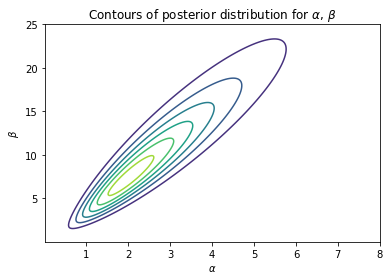

In [4]:
'''
Compute the un-normalized posterior density for alpha and beta and plot contours.
'''

from scipy.special import gammaln # log of the gamma function

# Work in logs to prevent underflows.
# The posterior density can be found in section 5.3 of BDA (equation 5.8)
def logposterior(a, b, data):
    post = (-5/2) * np.log(a + b)
    for j in range(len(data)):
        post += gammaln(a + b) - gammaln(a) - gammaln(b)
        post += gammaln(a + data.bicycles[j]) + gammaln(b + data.others[j]) - gammaln(a + b + data.bicycles[j] + data.others[j])
    return post

alphagrid = np.linspace(0.01, 8, 500)
betagrid = np.linspace(0.01, 25, 500)

X, Y = np.meshgrid(alphagrid, betagrid)
Z = logposterior(X, Y, df)
Z -= np.max(Z)
Z = np.exp(Z)
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
#ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Contours of posterior distribution for $\\alpha$, $\\beta$')
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$\\beta$')
plt.show()

array([[1.000e-02, 3.000e-02, 5.000e-02, ..., 1.995e+01, 1.997e+01,
        1.999e+01],
       [1.000e-02, 3.000e-02, 5.000e-02, ..., 1.995e+01, 1.997e+01,
        1.999e+01],
       [1.000e-02, 3.000e-02, 5.000e-02, ..., 1.995e+01, 1.997e+01,
        1.999e+01],
       ...,
       [1.000e-02, 3.000e-02, 5.000e-02, ..., 1.995e+01, 1.997e+01,
        1.999e+01],
       [1.000e-02, 3.000e-02, 5.000e-02, ..., 1.995e+01, 1.997e+01,
        1.999e+01],
       [1.000e-02, 3.000e-02, 5.000e-02, ..., 1.995e+01, 1.997e+01,
        1.999e+01]])

In [5]:
# Now let's calculate a normalized posterior density

alphagrid = np.arange(0.01, 20.01, 0.02)
betagrid = np.arange(0.01, 40.01, 0.02)
X, Y = np.meshgrid(alphagrid, betagrid)
Z = logposterior(X, Y, df)
Z -= np.max(Z)
Z = np.exp(Z)
normconst = np.sum(Z) * (0.02 ** 2) # Don't forget to scale by the grid size!
Z /= normconst

Now that we have a joint PDF for $\alpha, \beta$, we can use this to sample from the posterior by the following approach:
1. Find the marginal density of $\alpha$ by summing the joint PDF over $\beta$.
2. Draw samples of $\alpha$ from this marginal density.
3. For each sample value of $\alpha$, get the conditional density of $\beta$ by taking a slice from the joint PDF, and use this to draw a sample value of $\beta$.
4. For each sampled pair $(\alpha_i, \beta_i)$, draw a vector of $\theta_j$s from their posterior distribution $\theta_j \sim \mathrm{Beta}(\alpha_i + y_j, \beta_i + n_j - y_j)$.

Then we can examine our sampled $\theta_j$s to make inferences.

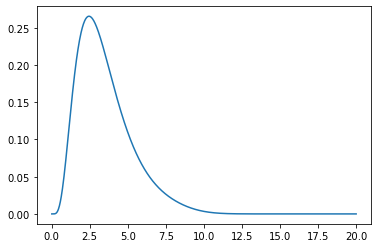

In [6]:
# Marginal posterior of alpha

margina = np.sum(Z, 0)
margina /= np.sum(margina * 0.02)
plt.plot(alphagrid, margina)

To sample from this distribution, we use the inverse-CDF method. Recall the CDF of a random variable is the function $F(x) = \mathrm{Pr}(X \leq x)$. If we know the inverse CDF $F^{-1}(p)$, we can feed it values uniformly drawn from $[0, 1]$ and obtain samples from the distribution of $X$. Below, we define a simple function to implement the inverse CDF method.

In [7]:
# Having estimated the pdf of alpha, we can draw samples from this distribution by the inverse-cdf method

def inverse_cdf(p, grid, pdf_array):
    '''
    Computes the inverse CDF of a probability given an estimated PDF evaluated on a grid.
    Parameters:    
    '''
    spacing = grid[1] - grid[0]
    totp = 0
    for i in range(len(grid)):
        if p < totp:
            return grid[i]
        totp += pdf_array[i] * spacing
    return grid[-1]

alpha_sample = []
for i in range(2000):
    x = np.random.rand()
    alpha_sample.append(inverse_cdf(x, alphagrid, margina))
alpha_sample = np.array(alpha_sample)
np.average(alpha_sample)

3.46065

In [8]:
beta_sample = []
for alpha in alpha_sample:
    idx = np.where(alphagrid == alpha)
    marginb = Z[:, idx[0][0]]
    marginb /= np.sum(marginb) * 0.02
    x = np.random.rand()
    beta_sample.append(inverse_cdf(x, betagrid, marginb))
beta_sample = np.array(beta_sample)
np.average(beta_sample)

13.571899999999998

In [9]:
# Finally we can sample some thetas
theta = np.zeros((2000, 10))
for i in range(2000):
    for j in range(10):
        theta[i,j] = sp.stats.beta.rvs(alpha_sample[i] + df.bicycles[j], beta_sample[i] + df.others[j])

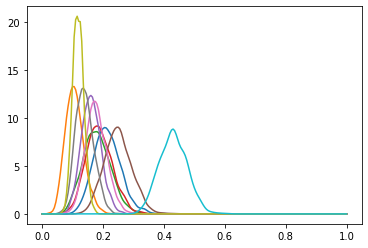

array([0.21381299, 0.1068924 , 0.17982375, 0.18804313, 0.16112769,
       0.24908847, 0.17751253, 0.13983891, 0.11858529, 0.43067996])

In [10]:
# Plot all the posteriors for thetas
for i in range(10):
    kernel = sp.stats.gaussian_kde(theta[:, i])
    grid = np.arange(0, 1.005, .005)
    plt.plot(grid, kernel(grid))
plt.show()

# Posterior means
np.average(theta, 0)

### The easy way

In [ ]:
def logp_ab(value):
    '''Transformation for the hyperprior. Theano tensor magic.'''
    return tt.log(tt.pow(tt.sum(value), -5/2))

with pm.Model() as hierarchical_model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab',
                     shape=2,
                     testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))

    # Distributions for theta
    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape = 10)
    
    # Data distribution
    y_obs = pm.Binomial('y_obs', p = theta, observed = df.bicycles, n=df.sum(axis=1))
    
    trace = pm.sample(2000, target_accept = 0.95)

In [ ]:
pm.summary(trace)

In [ ]:
for i in range(10):
    kernel = sp.stats.gaussian_kde(trace['theta'][:, i])
    grid = np.arange(0, 1.01, .01)
    plt.plot(grid, kernel(grid))
plt.show()

## A comparison

In [ ]:
separate_summary = pm.summary(separate_trace)
hier_summary = pm.summary(trace)

In [ ]:
plt.figure()
plt.plot(range(10), separate_summary['mean'], 'o', mfc='none', label = 'Separate effects model')
plt.plot(range(10), hier_summary[2:]['mean'], 'o', label = 'Hierarchical model')
plt.legend()
plt.show()